In [1]:
# module import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

C:\Users\user\miniconda3\envs\ml\lib\site-packages\requests\__init__.py:78: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({0}) or chardet ({1}) doesn't match a supported "


In [2]:
# 딥러닝 모델을 설계할때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
# 데이터 다운로드
train_dataset = datasets.MNIST(root='./'
                               , train=True,download=True,transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./'
                               , train=False,download=True,transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [5]:
# 데이터 확인1
for x_train,y_train in train_loader:
    print(f"x_train : {x_train.size()} type: {x_train.type()}")
    print(f"y_train : {y_train.size()} type: {y_train.type()}")
    break

x_train : torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train : torch.Size([32]) type: torch.LongTensor


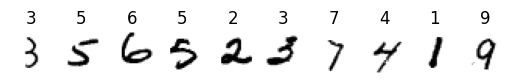

In [6]:
# 데이터 확인2
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.title(y_train[i].item()) 
    plt.imshow(x_train[i].numpy().reshape(28,28),cmap='gray_r')

In [17]:
# 모델 설계  L = 5  Linear 5
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)
        # self.fc2 = nn.Linear(512, 256)
        # self.fc3 = nn.Linear(256, 128)
        # self.fc4 = nn.Linear(128, 64)
        # self.fc5 = nn.Linear(64, 10)
        self.dropput_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512)
        
    def forward(self,x):   #히든층-출력함수-드랍아웃
        x = x.view(-1,28*28)  # 입력데이터를 2차원 행렬로 변경
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = torch.relu(x)
        x = torch.dropout(input=x, p=self.dropput_prob, train=self.training)        
        x = self.fc2(x)
        # x = torch.relu(x)
        # x = torch.dropout(input=x, p=self.dropput_prob, train=self.training)
        # x = self.fc3(x)
        # x = torch.relu(x)
        # x = torch.dropout(input=x, p=self.dropput_prob, train=self.training)
        # x = self.fc4(x)
        # x = torch.relu(x)
        # x = torch.dropout(input=x, p=self.dropput_prob, train=self.training)
        # x = self.fc5(x)
        x = torch.softmax(x,dim=1)
        return x

In [18]:
# model object, optimizer, loss function 생성
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [19]:
# 학습함수 : 학습진행, 진행상태
from tqdm import tqdm
def train(model, train_loader,optimizer):
    model.train()
    for (images, labels) in tqdm(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad() # 기울기를 업데이트 하지 않는다.. 즉 고정한다.
        output = model(images)
        loss = criterion(output, labels)
        loss.backward() # 오류 역전파
        optimizer.step() # 오류 역전파 값을 적용한다
        # if idx%100 == 0:
        #     print(f"loss : {loss.item()}")

In [20]:
# 평가 함수
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): #평가는 전방계산만 하고 역전파 안하기 때문에 가중치를 고정
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)            
            output = model(images)
            test_loss += criterion(output, labels).item()
            prediction = output.max(1,keepdim =True)[1]
            correct += prediction.eq(labels.view_as(prediction)).sum().item() 
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.* correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [21]:
# 학습진행
test_loss, test_accuracy = [],[],
for epoch in range(1, EPOCHS+1):
    train(model,train_loader,optimizer)
    tloss, taccuracy = evaluate(model,test_loader)
    test_loss.append(tloss)
    test_accuracy.append(taccuracy)
    print(f"epoch : {epoch} loss : {tloss}  accuracy : {taccuracy}")

100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:24<00:00, 75.81it/s]


epoch : 1 loss : 0.047309763860702514  accuracy : 95.38


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:24<00:00, 77.25it/s]


epoch : 2 loss : 0.046998671293258666  accuracy : 96.25


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:24<00:00, 75.61it/s]


epoch : 3 loss : 0.04685232895612717  accuracy : 96.63


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:24<00:00, 75.52it/s]


epoch : 4 loss : 0.04672949826717377  accuracy : 97.0


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:21<00:00, 86.54it/s]


epoch : 5 loss : 0.046607714796066284  accuracy : 97.37


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:20<00:00, 89.47it/s]


epoch : 6 loss : 0.0465742396235466  accuracy : 97.51


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 78.16it/s]


epoch : 7 loss : 0.04660997141599655  accuracy : 97.25


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:26<00:00, 70.85it/s]


epoch : 8 loss : 0.04657374492883682  accuracy : 97.4


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:22<00:00, 82.63it/s]


epoch : 9 loss : 0.04648741685152054  accuracy : 97.72


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:24<00:00, 75.75it/s]


epoch : 10 loss : 0.04655100234746933  accuracy : 97.46


In [ ]:
# plt.plot(range(1,11), test_loss)
plt.plot(range(1,11), test_accuracy)

In [22]:
# 초기화 방법에 따른 학습 효율의 변화
# 학습시작시점을 좋게 설정해서 학습이 좋은 방향으로 나아갈수 있도록 함

In [23]:
import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight.data)

model = Net().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
criterion = nn.CrossEntropyLoss()    

# 학습진행
weight_init_test_loss, weight_init_test_accuracy = [],[],
for epoch in range(1, EPOCHS+1):
    train(model,train_loader,optimizer)
    tloss, taccuracy = evaluate(model,test_loader)
    weight_init_test_loss.append(tloss)
    weight_init_test_accuracy.append(taccuracy)
    print(f"epoch : {epoch} loss : {tloss}  accuracy : {taccuracy}")

100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 80.84it/s]


epoch : 1 loss : 0.0474077947974205  accuracy : 95.11


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 79.10it/s]


epoch : 2 loss : 0.04698192805051803  accuracy : 96.36


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 79.71it/s]


epoch : 3 loss : 0.04683911890983582  accuracy : 96.76


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:22<00:00, 83.85it/s]


epoch : 4 loss : 0.046753851115703585  accuracy : 96.89


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:22<00:00, 84.09it/s]


epoch : 5 loss : 0.04667591199874878  accuracy : 97.17


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:23<00:00, 79.17it/s]


epoch : 6 loss : 0.046569552063941956  accuracy : 97.46


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:21<00:00, 87.80it/s]


epoch : 7 loss : 0.04659095020294189  accuracy : 97.38


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:25<00:00, 74.54it/s]


epoch : 8 loss : 0.046562024772167206  accuracy : 97.46


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:26<00:00, 69.80it/s]


epoch : 9 loss : 0.046556088399887084  accuracy : 97.51


100%|███████████████████████████████████████████████████████████████| 1875/1875 [00:29<00:00, 64.32it/s]


epoch : 10 loss : 0.04647438786029816  accuracy : 97.64


In [ ]:
# autoEncorder 이용
# 앞 부분을 hidden layer로 압축시킨뒤 output부분을 input과 동일하게 만들어서 decoding 

In [24]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,28*28),
        )
    def forward(self,x):
        encorder = self.encoder(x)
        decorder = self.decoder(encoder)
        return encorder, decorder

In [26]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
criterion = nn.MSELoss()
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)
